## Tinkoff Data Challenge
### Задача 1. 
https://boosters.pro/champ_3#

In [1]:
%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
import pandas as pd
import numpy as np
import sklearn
import os 

### Загрузка данных

In [3]:
df_train = pd.read_csv('./data/tdc/credit_train.csv',encoding = 'cp1251',sep = ';')
df_test = pd.read_csv('./data/tdc/credit_test.csv',encoding = 'cp1251',sep = ';')

In [4]:
df_train.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000,1,1,0
1,2,F,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,МОСКВА,43000,2,0,0
2,3,M,32,MAR,SPC,"10728,00",12,1.1,"0,459589",SCH,ОБЛ САРАТОВСКАЯ,23000,5,0,0
3,4,F,27,DIV,SPC,"12009,09",12,1.1,"0,362536",GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000,2,0,0
4,5,M,45,MAR,SPC,"16908,89",10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000,1,0,0


###Обработка данных

In [5]:
def replace_comma(df,col_name):
    '''
    Replace comma by dot in col_name columns of df pandas DataFrame and transform into number.
    '''
    df[col_name] = df[col_name].map(lambda v:float(v.replace(',','.')))

replace_comma(df_train,'credit_sum')
replace_comma(df_train,'score_shk')
replace_comma(df_test,'credit_sum')
replace_comma(df_test,'score_shk')

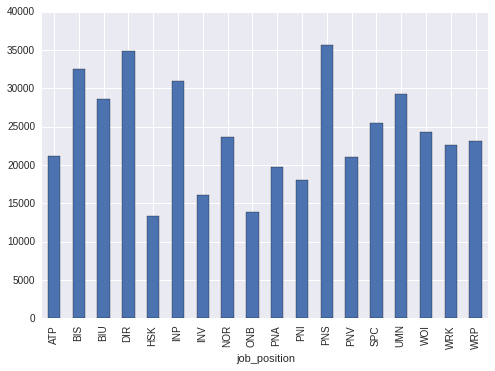

In [6]:
df_train.groupby('job_position')['credit_sum'].mean().plot('bar')

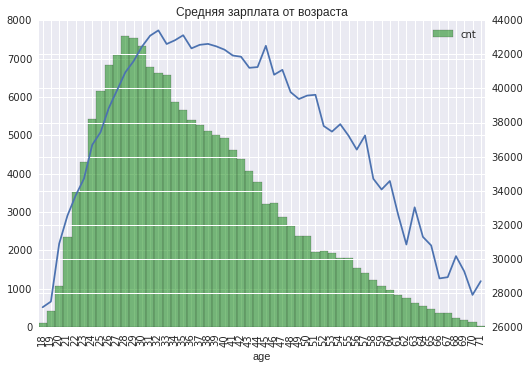

In [68]:
#df_train.groupby('age')['monthly_income'].mean().plot('line')
#fig, ax = plt.subplots(2, 1)
dfp =  df_train.groupby('age')['monthly_income'].agg({'mean':np.mean,'cnt':np.size})

ax = dfp[['cnt']].plot(kind="bar",color = 'g',alpha = 0.5, width = 1,label = 'cnt')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),dfp[['mean']],label = 'mean')   
plt.xticks(rotation=0)
plt.title(u'Средняя зарплата от возраста')


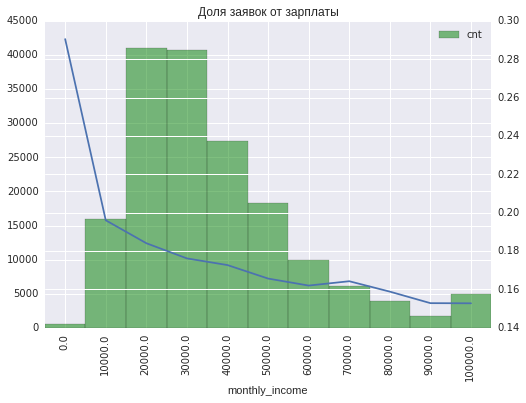

In [88]:
def cast_int(v):
    try:
        return 10000 * min(int(v/10000),10)
    except:
        return None
    
dfp = df_train.groupby((df_train['monthly_income']).map(cast_int))['open_account_flg'].agg({'mean':np.mean,'cnt':np.size})
ax = dfp[['cnt']].plot(kind="bar",color = 'g',alpha = 0.5, width = 1,label = 'cnt')
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),dfp[['mean']],label = 'mean')   
plt.xticks(rotation=0)
plt.title(u'Доля заявок от зарплаты')

#.mean().plot(title = u'Доля заявок от зарплаты')

In [111]:
#Преобразуем строковые категориальные факторы в числовые
df_train['tariff_id_str'] = df_train['tariff_id'].astype(str)
df_test['tariff_id_str'] = df_test['tariff_id'].astype(str)

str_cols = ['gender','marital_status','job_position','education','living_region','tariff_id_str']

df_train1 = pd.get_dummies(df_train, columns = str_cols)
df_test1 = pd.get_dummies(df_test, columns = str_cols)

In [81]:
feat_cols = [c for c in df_train1.columns if c not in ['client_id','open_account_flg'] + str_cols ]
label = 'open_account_flg'

train_idx, valid_idx = sklearn.model_selection.train_test_split(df_train1.index,test_size = 0.3)

In [85]:
import sklearn.linear_model
clfLR = sklearn.linear_model.LogisticRegression()

clfLR.fit(df_train1.loc[train_idx,feat_cols].fillna(-100), df_train1.loc[train_idx,label])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
#import sklearn.metrics.roc_auc_score
print('Logistic regression without normalization AUC ROC on valid data: {:.4f}'.format(
    sklearn.metrics.roc_auc_score(
            y_true  = df_train1.loc[valid_idx,label],
            y_score = clfLR.predict_proba(df_train1.loc[valid_idx,feat_cols].fillna(-100))[:,1]
    )
))


Logistic regression withou normalization AUC ROC on valid data: 0.5729


### LightGBM

In [121]:
import pylightgbm
from pylightgbm.models import GBMClassifier

# full path to lightgbm executable (on Windows include .exe)
lgbm_exec_path = "/opt/share/LightGBM-master/lightgbm"

clfGBM = GBMClassifier(exec_path=lgbm_exec_path,num_iterations=200, verbose = False)
clfGBM.fit(df_train1.loc[train_idx,feat_cols], df_train1.loc[train_idx,label])

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable


In [123]:
print('LightGBM AUC ROC on valid data: {:.4f}'.format(
    sklearn.metrics.roc_auc_score(
            y_true  = df_train1.loc[valid_idx,label],
            y_score = clfGBM.predict_proba(df_train1.loc[valid_idx,feat_cols])[:,1]
    )
))


LightGBM AUC ROC on valid data: 0.7589


In [113]:
import xgboost as xgb
dtrain_xgb = xgb.DMatrix( df_train1.loc[train_idx,feat_cols], label = df_train1.loc[train_idx,label], missing = np.nan)
dvalid_xgb = xgb.DMatrix( df_train1.loc[valid_idx,feat_cols], label = df_train1.loc[valid_idx,label], missing = np.nan)
dtest_xgb  = xgb.DMatrix( df_test1.loc[:,feat_cols], missing = np.nan)

In [109]:

param = {
    'bst:max_depth': 6,     
    'silent': 1, 
    'objective':'binary:logistic', 
    'alpha': 1, 
    'tree_method':'approx',
    'learning_rate': 0.04,
    'eval_metric' : ['logloss','auc']
}
#'bst:eta':1, 
#    'tree_method':'approx',
evallist  = [ (dtrain_xgb,'train'),(dvalid_xgb,'valid')]
num_round = 200
bst = xgb.train( param, dtrain_xgb, num_round, evallist, early_stopping_rounds = 20)
print(bst.best_iteration)

Will train until valid error hasn't decreased in 20 rounds.
Multiple eval metrics have been passed: 'auc' will be used for early stopping.

[0]	train-logloss:0.674156	train-auc:0.722228	valid-logloss:0.674290	valid-auc:0.718668
[1]	train-logloss:0.656642	train-auc:0.722845	valid-logloss:0.656905	valid-auc:0.719338
[2]	train-logloss:0.640426	train-auc:0.727059	valid-logloss:0.640840	valid-auc:0.723589
[3]	train-logloss:0.625420	train-auc:0.728548	valid-logloss:0.626019	valid-auc:0.724640
[4]	train-logloss:0.611466	train-auc:0.732169	valid-logloss:0.612193	valid-auc:0.727402
[5]	train-logloss:0.598464	train-auc:0.732508	valid-logloss:0.599370	valid-auc:0.727781
[6]	train-logloss:0.586427	train-auc:0.733408	valid-logloss:0.587459	valid-auc:0.728255
[7]	train-logloss:0.575186	train-auc:0.733944	valid-logloss:0.576384	valid-auc:0.728587
[8]	train-logloss:0.564687	train-auc:0.734253	valid-logloss:0.566014	valid-auc:0.728922
[9]	train-logloss:0.554947	train-auc:0.734776	valid-logloss:0.556406

199


[199]	train-logloss:0.384879	train-auc:0.786782	valid-logloss:0.399547	valid-auc:0.764745


In [117]:
df_test1['pred_xgb'] = bst.predict(dtest_xgb)

In [120]:
df_test1[['client_id','pred_xgb']].to_csv('data/tbc_submit1.csv',index = False, header = False)

In [126]:
df_train.columns

Index([           u'client_id',               u'gender',
                        u'age',       u'marital_status',
               u'job_position',           u'credit_sum',
               u'credit_month',            u'tariff_id',
                  u'score_shk',            u'education',
              u'living_region',       u'monthly_income',
               u'credit_count', u'overdue_credit_count',
           u'open_account_flg',        u'tariff_id_str'],
      dtype='object')

In [147]:
df_train[u'living_region'].map(lambda r: r.replace(u'ОБЛАСТЬ','').replace(u'ОБЛ','').replace('-','').replace(' ','') if r else '').unique()


AttributeError: 'float' object has no attribute 'replace'

In [148]:
#sorted(df_train[u'living_region'].unique())
